In [5]:
"""
NormWear-Compatible LBNP Data Preparation Pipeline
--------------------------------------------------
- Loads 23 subjects × 3 trials (.csv)
- Resamples signals from 1000 Hz → 64 Hz
- Interpolates NaNs, normalizes channels
- Windows data (15 s = 960 samples)
    * Training: 10 s overlap
    * Testing:  no overlap
- Computes per-window 3-class + SV labels
- Saves each window as .pkl (float16)
- Generates deterministic 3-fold subject splits (8/8/7)
"""

import os
import json
import pickle
import numpy as np
import pandas as pd
from scipy.signal import resample_poly
from pathlib import Path


# -------------------------
# Configuration
# -------------------------
csv_dir = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/csv_export")
output_dir = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/pkl_windows_normwear")
output_dir.mkdir(parents=True, exist_ok=True)

fs_orig = 1000
fs_new = 64
window_duration_sec = 15
window_size = window_duration_sec * fs_new  # 960 samples
train_overlap_sec = 10
train_step_size = window_size - train_overlap_sec * fs_new  # 320-step overlap
test_step_size = window_size  # no overlap


In [19]:
# -------------------------
# Helper Functions
# -------------------------
def resample_signal(x, labels, sv, fs_orig=1000, fs_new=64):
    """Resample multi-channel signals, labels, and SV to new sampling rate."""
    ratio = fs_new / fs_orig
    n_new = int(x.shape[1] * ratio)
    x_res = resample_poly(x, fs_new, fs_orig, axis=1)
    labels_res = resample_poly(labels, fs_new, fs_orig)
    sv_res = resample_poly(sv, fs_new, fs_orig)
    return x_res, labels_res.squeeze(), sv_res.squeeze()


def interpolate_nans(x_array):
    """Linearly interpolate NaNs for each channel."""
    x_interp = np.copy(x_array)
    n_channels, n_samples = x_array.shape
    for i in range(n_channels):
        ch = x_array[i, :]
        nans = np.isnan(ch)
        if np.any(nans):
            not_nan = np.where(~nans)[0]
            if len(not_nan) == 0:
                print(f"⚠️ Channel {i} is all NaN.")
                continue
            x_interp[i, nans] = np.interp(np.where(nans)[0], not_nan, ch[not_nan])
    return x_interp


def level_to_class(level):
    """Map 7-level LBNP to 3-class severity."""
    if level <= 2:
        return 1  # mild
    elif level <= 4:
        return 2  # moderate
    else:
        return 3  # severe


def make_windows(x_norm, labels_res, sv_res, subj_id, trial_id, step_size, phase="train"):
    """Create and save 15 s windows for a given subject & trial."""
    n_samples = x_norm.shape[1]
    start, win_idx = 0, 0
    pkl_names = []

    while start + window_size <= n_samples:
        end = start + window_size
        x_win = x_norm[:, start:end].astype(np.float16)
        label_win = int(np.bincount(labels_res[start:end].astype(int)).argmax())
        class_label = level_to_class(label_win)
        sv_mean = float(np.mean(sv_res[start:end]))

        uid = f"Subj_{subj_id}_Ser_{trial_id}_win_{win_idx:03d}"
        win_data = {
            "uid": uid,
            "data": x_win,
            "sampling_rate": fs_new,
            "label": [
                {"class": class_label},
                {"reg": sv_mean}
            ]
        }

        out_path = output_dir / f"{uid}.pkl"
        with open(out_path, "wb") as f:
            pickle.dump(win_data, f)
        pkl_names.append((subj_id, out_path.name))

        win_idx += 1
        start += step_size

    print(f"  ➤ {len(pkl_names)} windows saved for Subj {subj_id} Trial {trial_id} ({phase})")
    return pkl_names

In [20]:
# -------------------------
# Main Processing Loop
# -------------------------
subjects = sorted(list({int(f.stem.split("_")[1]) for f in csv_dir.glob("Subj_*_Ser_*_app.csv")}))
csv_files = sorted(csv_dir.glob("Subj_*_Ser_*_app.csv"))
assert len(subjects) == 23, f"Expected 23 subjects, found {len(subjects)}"

all_pkl_files = []

# Deterministic 3-Fold Split
folds = {
    1: {"train": subjects[:16], "test": subjects[16:]},                  # 1–16 train, 17–23 test
    2: {"train": subjects[7:], "test": subjects[:7]},                   # 8–23 train, 1–7 test
    3: {"train": subjects[3:19], "test": subjects[:3] + subjects[19:]}  # 4–19 train, 1–3,20–23 test
}

# Process all trials
for csv_file in csv_files:
    subj_id = int(csv_file.stem.split("_")[1])
    trial_id = int(csv_file.stem.split("_")[3])
    df = pd.read_csv(csv_file)

    channels = [
        "EKGPowerlab", "LBNP", "SD50", "EKG_SD50", "Photopleth",
        "SpO2", "ABP_rd_ledning", "Kapnografi", "Nexfin_SV",
        "Nexfin_ABP", "EKG_kopi", "Heart_rate"
    ]
    x = df[channels].to_numpy().T
    labels = df["Labels"].to_numpy()
    sv = df["Nexfin_SV"].to_numpy()

    # Preprocess
    x_res, labels_res, sv_res = resample_signal(x, labels, sv, fs_orig, fs_new)
    x_res = interpolate_nans(x_res)
    sv_res = np.nan_to_num(sv_res, nan=np.nanmean(sv_res))
    labels_res = np.nan_to_num(labels_res, nan=1)

    # Normalize
    mean, std = np.mean(x_res, axis=1, keepdims=True), np.std(x_res, axis=1, keepdims=True)
    std[std == 0] = 1
    x_norm = (x_res - mean) / std

    # Determine fold membership
    fold_id = None
    for f_id, sets in folds.items():
        if subj_id in sets["train"]:
            fold_id = f_id
            step = train_step_size
            phase = "train"
            break
        elif subj_id in sets["test"]:
            fold_id = f_id
            step = test_step_size
            phase = "test"
            break
    if fold_id is None:
        raise ValueError(f"Subject {subj_id} not assigned to any fold!")

    # Windowing and saving
    all_pkl_files.extend(make_windows(x_norm, labels_res, sv_res, subj_id, trial_id, step, phase=phase))

print(f"\n✅ Total windows saved: {len(all_pkl_files)}")


  ➤ 190 windows saved for Subj 10 Trial 1 (train)
  ➤ 208 windows saved for Subj 10 Trial 2 (train)
  ➤ 174 windows saved for Subj 10 Trial 3 (train)
  ➤ 196 windows saved for Subj 11 Trial 1 (train)
  ➤ 178 windows saved for Subj 11 Trial 2 (train)
  ➤ 214 windows saved for Subj 11 Trial 3 (train)
  ➤ 202 windows saved for Subj 12 Trial 1 (train)
  ➤ 202 windows saved for Subj 12 Trial 2 (train)
  ➤ 226 windows saved for Subj 12 Trial 3 (train)
  ➤ 201 windows saved for Subj 13 Trial 1 (train)
  ➤ 225 windows saved for Subj 13 Trial 2 (train)
  ➤ 237 windows saved for Subj 13 Trial 3 (train)
  ➤ 225 windows saved for Subj 14 Trial 1 (train)
  ➤ 226 windows saved for Subj 14 Trial 2 (train)
  ➤ 226 windows saved for Subj 14 Trial 3 (train)
  ➤ 238 windows saved for Subj 15 Trial 1 (train)
  ➤ 214 windows saved for Subj 15 Trial 2 (train)
  ➤ 189 windows saved for Subj 15 Trial 3 (train)
  ➤ 226 windows saved for Subj 16 Trial 1 (train)
  ➤ 213 windows saved for Subj 16 Trial 2 (train)


In [21]:
# -------------------------
# Generate train/test JSON splits
# -------------------------
fold_jsons = []
for fold_idx, split in folds.items():
    train_subjects = split["train"]
    test_subjects = split["test"]

    train_files = [name for subj, name in all_pkl_files if subj in train_subjects]
    test_files = [name for subj, name in all_pkl_files if subj in test_subjects]

    split_dict = {"train": train_files, "test": test_files}
    json_path = output_dir / f"train_test_split_fold{fold_idx}.json"
    with open(json_path, "w") as f:
        json.dump(split_dict, f, indent=2)
    fold_jsons.append(json_path)

print("\n✅ Deterministic subject-based 3-fold CV split files generated:")
for j in fold_jsons:
    print("  ", j.name)


✅ Deterministic subject-based 3-fold CV split files generated:
   train_test_split_fold1.json
   train_test_split_fold2.json
   train_test_split_fold3.json


In [22]:
import pickle
import json
from collections import Counter

# --- Step 1: Verify structure of one sample .pkl ---
sample_pkl = next(output_dir.glob("Subj_1_Ser_1_win_000.pkl"))
with open(sample_pkl, "rb") as f:
    sample_data = pickle.load(f)

print("Sample UID:", sample_data["uid"])
print("Sampling rate:", sample_data["sampling_rate"])
print("Data shape:", sample_data["data"].shape)
print("Data dtype:", sample_data["data"].dtype)
print("Labels:", sample_data["label"])
print("✅ Structure check OK if matches NormWear format")

# --- Step 2: Summarize windows per fold ---
def summarize_fold(json_path):
    with open(json_path, "r") as f:
        split = json.load(f)
    counts = {"train": Counter(), "test": Counter()}
    for subset in ["train", "test"]:
        for pkl_name in split[subset]:
            pkl_path = output_dir / pkl_name
            with open(pkl_path, "rb") as f:
                data = pickle.load(f)
            cls = data["label"][0]["class"]
            counts[subset][cls] += 1
    return counts

fold_summaries = {}
for fold_idx in [1, 2, 3]:
    json_path = output_dir / f"train_test_split_fold{fold_idx}.json"
    counts = summarize_fold(json_path)
    fold_summaries[fold_idx] = counts
    print(f"\n📊 Fold {fold_idx} summary:")
    print("Train:", dict(counts["train"]))
    print("Test:", dict(counts["test"]))

# --- Step 3: Overall totals ---
total_counts = Counter()
for fsum in fold_summaries.values():
    total_counts.update(fsum["train"])
    total_counts.update(fsum["test"])

print("\n🔢 Overall window count by class (all folds):")
for cls, n in sorted(total_counts.items()):
    label = {1: "mild", 2: "moderate", 3: "severe"}[cls]
    print(f"  Class {cls} ({label}): {n} windows")



Sample UID: Subj_1_Ser_1_win_000
Sampling rate: 64
Data shape: (12, 960)
Data dtype: float16
Labels: [{'class': 1}, {'reg': 106.73747422156671}]
✅ Structure check OK if matches NormWear format

📊 Fold 1 summary:
Train: {1: 4351, 2: 3337, 3: 2501}
Test: {1: 570, 2: 586, 3: 379}

📊 Fold 2 summary:
Train: {1: 3078, 2: 2366, 3: 1776}
Test: {1: 1843, 2: 1557, 3: 1104}

📊 Fold 3 summary:
Train: {1: 3945, 2: 2897, 3: 2147}
Test: {1: 976, 2: 1026, 3: 733}

🔢 Overall window count by class (all folds):
  Class 1 (mild): 14763 windows
  Class 2 (moderate): 11769 windows
  Class 3 (severe): 8640 windows


Found 71 windows for Subj_21 Ser_3


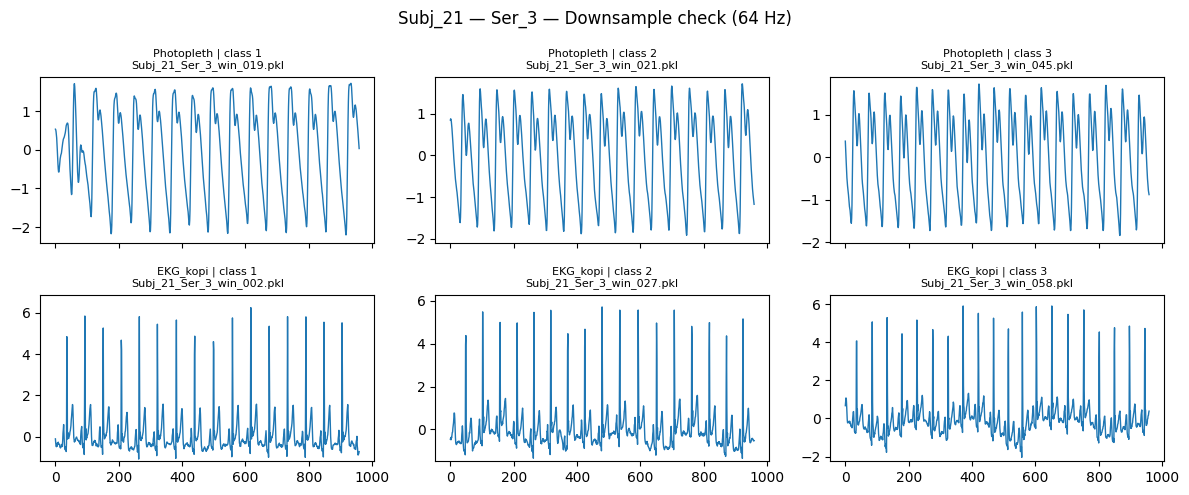

In [54]:
import pickle, random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict

# choose subject and base dir
data_dir = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/pkl_windows_normwear")
subject = "Subj_21"
trial = "Ser_3"  # pick the trial/session

# gather all files for this subject and trial
trial_files = [f for f in data_dir.glob(f"{subject}_{trial}_win_*.pkl")]
print(f"Found {len(trial_files)} windows for {subject} {trial}")

# group windows by class
class_files = defaultdict(list)
for f in trial_files:
    with open(f, "rb") as fh:
        d = pickle.load(fh)
        label = d["label"][0]["class"]
        class_files[label].append(f)

for cl in [1,2,3]:
    if cl not in class_files or len(class_files[cl]) == 0:
        print(f"⚠️ No windows found for class {cl} in {trial}")

# pick one random window per class
def pick_random_window(files_list):
    return random.choice(files_list) if files_list else None

channels_to_plot = ["Photopleth", "EKG_kopi"]
channel_idx_map = {"Photopleth": 4, "EKG_kopi": 3}  # adjust if needed
fig, axs = plt.subplots(len(channels_to_plot), 3, figsize=(12, 5), sharex=True)
if len(channels_to_plot) == 1:
    axs = np.expand_dims(axs, 0)

for ci, ch in enumerate(channels_to_plot):
    for c, cl in enumerate([1,2,3]):
        f = pick_random_window(class_files.get(cl, []))
        if f is None:
            axs[ci, c].set_visible(False)
            continue
        with open(f, "rb") as fh:
            data = pickle.load(fh)
        y = data["data"][channel_idx_map[ch]]
        axs[ci, c].plot(y, lw=1)
        axs[ci, c].set_title(f"{ch} | class {cl}\n{f.name}", fontsize=8)
        axs[ci, c].set_ylim(np.min(y)*1.1, np.max(y)*1.1)

plt.suptitle(f"{subject} — {trial} — Downsample check (64 Hz)", fontsize=12)
plt.tight_layout()
plt.show()


In [32]:
import pickle
from pathlib import Path

data_dir = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/pkl_windows_normwear")
subject = "Subj_1"

# pick a random file
sample_file = list(data_dir.glob(f"{subject}*.pkl"))[0]
print("Loading:", sample_file.name)

with open(sample_file, "rb") as f:
    data = pickle.load(f)

# inspect keys and type
print("Keys in pickle:", data.keys() if hasattr(data, "keys") else type(data))
print("Type of 'data':", type(data.get("data") if "data" in data else "N/A"))

# optionally, print shapes or first few elements
if "data" in data:
    if isinstance(data["data"], dict):
        for k, v in data["data"].items():
            print(k, np.shape(v))
    else:
        print(np.shape(data["data"]))

# check if there is a labels key
for k in data.keys():
    if "label" in k.lower():
        print(k, data[k])



Loading: Subj_10_Ser_1_win_000.pkl
Keys in pickle: dict_keys(['uid', 'data', 'sampling_rate', 'label'])
Type of 'data': <class 'numpy.ndarray'>
(12, 960)
label [{'class': 1}, {'reg': 110.85773360744722}]


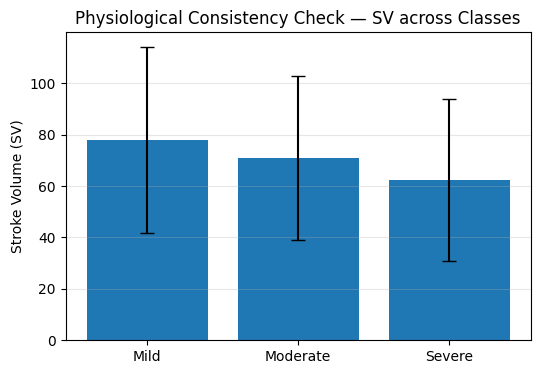

Class 1: mean SV = 77.94 ± 36.21
Class 2: mean SV = 71.10 ± 31.90
Class 3: mean SV = 62.43 ± 31.47


In [19]:
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import json

# directories
pkl_dir = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/pkl_windows_normwear")
split_json = pkl_dir / "train_test_split_fold1.json"  # any fold works

# load split
with open(split_json) as f:
    split = json.load(f)

# collect SV by class
sv_by_class = {1: [], 2: [], 3: []}

for subset in [ "test"]:
    for fname in split[subset]:
        with open(pkl_dir / fname, "rb") as fh:
            d = pickle.load(fh)
        lbl = d["label"][0]["class"]
        sv = d["label"][1]["reg"]
        sv_by_class[lbl].append(sv)

# compute mean ± std
means = [np.mean(sv_by_class[c]) for c in [1,2,3]]
stds = [np.std(sv_by_class[c]) for c in [1,2,3]]

# plot
plt.figure(figsize=(6,4))
plt.bar(["Mild", "Moderate", "Severe"], means, yerr=stds, capsize=5)
plt.ylabel("Stroke Volume (SV)")
plt.title("Physiological Consistency Check — SV across Classes")
plt.grid(axis='y', alpha=0.3)
plt.show()

# print summary
for c, (m, s) in zip([1,2,3], zip(means, stds)):
    print(f"Class {c}: mean SV = {m:.2f} ± {s:.2f}")


/tmp/ipykernel_644889/2381604522.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="SV", data=df, palette="pastel", showfliers=False)


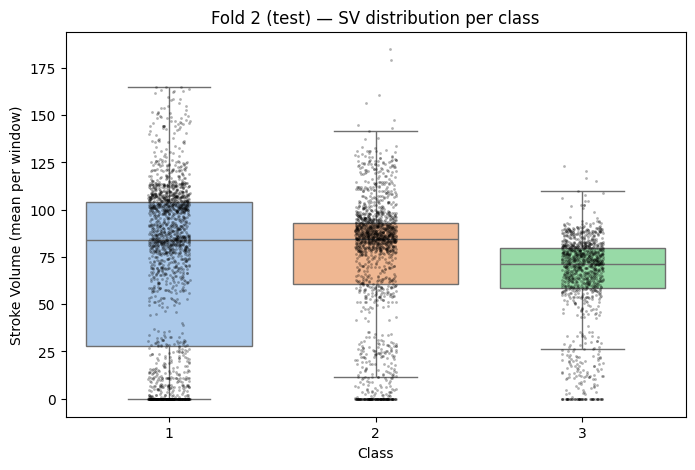

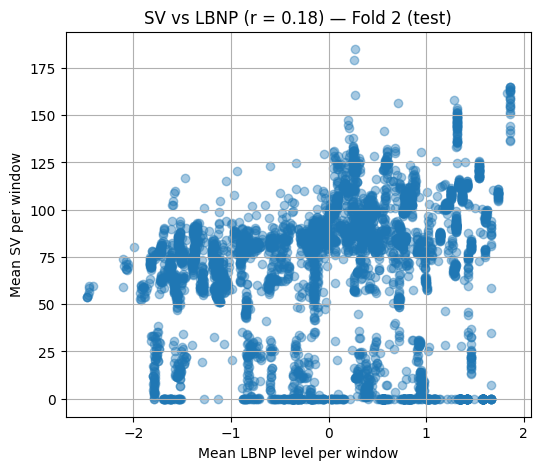

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
fold_id = 2 # change to 2 or 3 for other folds
subset_to_check = "test"  # or "train" if you want training subset

split_json = pkl_dir / f"train_test_split_fold{fold_id}.json"
with open(split_json) as f:
    split = json.load(f)

sv_by_class = {1: [], 2: [], 3: []}
lbnps, svs = [], []

# --- Load data from PKL files ---
for fname in split[subset_to_check]:
    with open(pkl_dir / fname, "rb") as fh:
        d = pickle.load(fh)
    cls = d["label"][0]["class"]
    sv = d["label"][1]["reg"]
    sv_by_class[cls].append(sv)

    # Try to include LBNP channel if available
    ch_names = ["EKGPowerlab", "LBNP", "SD50", "EKG_SD50", "Photopleth",
                "SpO2", "ABP_rd_ledning", "Kapnografi", "Nexfin_SV",
                "Nexfin_ABP", "EKG_kopi", "Heart_rate"]
    if "LBNP" in ch_names:
        idx = ch_names.index("LBNP")
        lbnps.append(np.mean(d["data"][idx, :]))
        svs.append(sv)

# --- 📊 1) Boxplot: SV distribution per class ---
plt.figure(figsize=(8,5))
data = [(c, sv) for c, vals in sv_by_class.items() for sv in vals]
df = pd.DataFrame(data, columns=["Class", "SV"])
sns.boxplot(x="Class", y="SV", data=df, palette="pastel", showfliers=False)
sns.stripplot(x="Class", y="SV", data=df, color="k", alpha=0.3, size=2)
plt.title(f"Fold {fold_id} ({subset_to_check}) — SV distribution per class")
plt.ylabel("Stroke Volume (mean per window)")
plt.show()

# --- 📈 2) Scatter: SV vs LBNP mean level (if available) ---
if len(lbnps) > 0:
    plt.figure(figsize=(6,5))
    plt.scatter(lbnps, svs, alpha=0.4)
    r = np.corrcoef(lbnps, svs)[0,1]
    plt.title(f"SV vs LBNP (r = {r:.2f}) — Fold {fold_id} ({subset_to_check})")
    plt.xlabel("Mean LBNP level per window")
    plt.ylabel("Mean SV per window")
    plt.grid(True)
    plt.show()
else:
    print("⚠️ LBNP channel not found in PKL data — correlation plot skipped.")


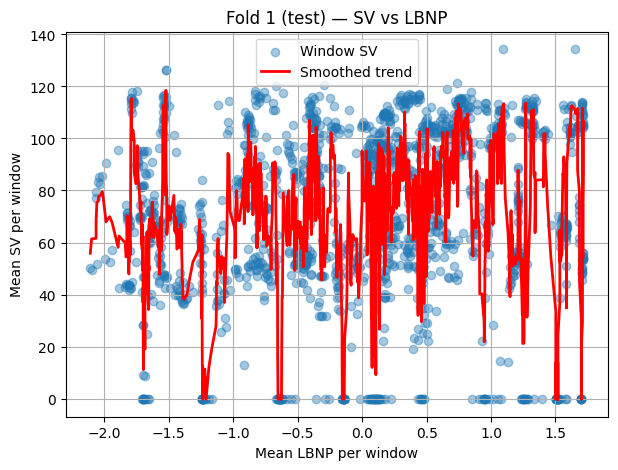

In [27]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from scipy.ndimage import uniform_filter1d

# --- CONFIG ---
fold_id = 1
subset_to_check = "test"  # "train" is fine too
pkl_dir = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/pkl_windows_normwear")
split_json = pkl_dir / f"train_test_split_fold{fold_id}.json"

# --- Load split ---
with open(split_json) as f:
    split = json.load(f)

lbnp_vals, sv_vals = [], []

for fname in split[subset_to_check]:
    with open(pkl_dir / fname, "rb") as fh:
        d = pickle.load(fh)
    sv = d["label"][1]["reg"]
    # LBNP channel is assumed at index 1 ("LBNP")
    lbnp = np.mean(d["data"][1, :])
    lbnp_vals.append(lbnp)
    sv_vals.append(sv)

lbnp_vals = np.array(lbnp_vals)
sv_vals = np.array(sv_vals)

# Sort for smooth plotting
sort_idx = np.argsort(lbnp_vals)
lbnp_sorted = lbnp_vals[sort_idx]
sv_sorted = sv_vals[sort_idx]

# Smooth SV with moving average for trend
sv_smooth = uniform_filter1d(sv_sorted, size=5)

# --- Plot ---
plt.figure(figsize=(7,5))
plt.scatter(lbnp_sorted, sv_sorted, alpha=0.4, label="Window SV")
plt.plot(lbnp_sorted, sv_smooth, color="r", lw=2, label="Smoothed trend")
plt.xlabel("Mean LBNP per window")
plt.ylabel("Mean SV per window")
plt.title(f"Fold {fold_id} ({subset_to_check}) — SV vs LBNP")
plt.grid(True)
plt.legend()
plt.show()


In [37]:
import torch
from pathlib import Path

# --- CONFIG ---
ckpt_path = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/normwear_last_checkpoint-15470-correct.pth")

# --- Load checkpoint safely ---
print(f"🔍 Loading checkpoint from: {ckpt_path.name}")
checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

# --- Top-level keys ---
print("\n📦 Checkpoint top-level keys:")
for k in checkpoint.keys():
    print("  ", k)

# --- Extract model state dict ---
# Depending on how the checkpoint was saved, weights may be under "model"
state_dict = checkpoint.get("model", checkpoint)

# --- Search for first conv/proj/embedding layer ---
print("\n🔍 Input layer details and shapes of conv/linear layers:\n")
first_layer_info = None
for name, param in state_dict.items():
    if "conv" in name.lower() or "proj" in name.lower() or "embedding" in name.lower():
        shape = tuple(param.shape)
        if first_layer_info is None:
            first_layer_info = (name, shape)  # store first matching layer
        if len(shape) >= 3:  # Conv-like [out_channels, in_channels, kernel]
            print(f"{name:50s}  Conv-like shape={shape}")
        elif len(shape) == 2:  # Linear-like [out_features, in_features]
            print(f"{name:50s}  Linear-like shape={shape}")

if first_layer_info:
    name, shape = first_layer_info
    in_channels = shape[1] if len(shape) >= 2 else None
    print(f"\n✅ First input layer: {name}")
    print(f"   Expected number of input channels: {in_channels}")
else:
    print("⚠️ No conv/proj/embedding layer found in checkpoint.")


🔍 Loading checkpoint from: normwear_last_checkpoint-15470-correct.pth

📦 Checkpoint top-level keys:
   model
   optimizer
   epoch
   scaler
   args

🔍 Input layer details and shapes of conv/linear layers:

patch_embed.proj.weight                             Conv-like shape=(768, 3, 9, 5)
encoder_blocks.0.variate_encoder.attn.proj.weight   Linear-like shape=(768, 768)
encoder_blocks.0.cls_fusion.attn.proj.weight        Linear-like shape=(768, 768)
encoder_blocks.1.variate_encoder.attn.proj.weight   Linear-like shape=(768, 768)
encoder_blocks.2.variate_encoder.attn.proj.weight   Linear-like shape=(768, 768)
encoder_blocks.2.cls_fusion.attn.proj.weight        Linear-like shape=(768, 768)
encoder_blocks.3.variate_encoder.attn.proj.weight   Linear-like shape=(768, 768)
encoder_blocks.4.variate_encoder.attn.proj.weight   Linear-like shape=(768, 768)
encoder_blocks.4.cls_fusion.attn.proj.weight        Linear-like shape=(768, 768)
encoder_blocks.5.variate_encoder.attn.proj.weight   Linear-lik

In [31]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path

class LBNPDataset(Dataset):
    def __init__(self, pkl_dir, file_list, channels=["EKG_kopi", "Photopleth", "LBNP"], transform=None):
        """
        Args:
            pkl_dir (Path): Directory containing .pkl windows
            file_list (list[str]): list of filenames to use
            channels (list[str]): channels to extract
            transform (callable, optional): optional transform on the data
        """
        self.pkl_dir = Path(pkl_dir)
        self.file_list = file_list
        self.channels = channels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        with open(self.pkl_dir / fname, "rb") as fh:
            d = pickle.load(fh)

        data = d["data"]  # shape: [num_channels, time]
        # Map channel names to indices
        channel_names = ["ChannelTitle", "EKGPowerlab", "LBNP", "SD50", "EKG_SD50", 
                         "Photopleth","SpO2","ABP_rd_ledning","Kapnografi",
                         "Nexfin_SV","Nexfin_ABP","EKG_kopi","Heart_rate","Respiratory_rate"]
        ch_idx = []
        for ch in self.channels:
            if ch in channel_names:
                ch_idx.append(channel_names.index(ch))
            else:
                raise ValueError(f"Channel {ch} not found in data")

        x = data[ch_idx, :].astype(np.float32)  # [selected_channels, time]

        # Z-score normalization per channel
        x = (x - x.mean(axis=1, keepdims=True)) / (x.std(axis=1, keepdims=True) + 1e-6)

        # Classification target (3-class LBNP)
        y_class = d["label"][0]["class"] - 1  # convert to 0-indexed
        y_class = torch.tensor(y_class, dtype=torch.long)

        # Regression target (SV mean)
        y_reg = d["label"][1]["reg"]
        y_reg = torch.tensor(y_reg, dtype=torch.float32)

        x = torch.tensor(x)  # [C, T]

        if self.transform:
            x = self.transform(x)

        return x, y_class, y_reg


# --- Example usage ---

pkl_dir = "/media/Naimahmed/Data/LBNP/Lbnp/level7/pkl_windows_normwear"
# Example: use all windows for Subj_1
file_list = [f.name for f in Path(pkl_dir).glob("Subj_1*.pkl")]

dataset = LBNPDataset(pkl_dir, file_list)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Check one batch
x, y_class, y_reg = next(iter(dataloader))
print("x.shape:", x.shape)          # [batch, channels, time]
print("y_class.shape:", y_class.shape)
print("y_reg.shape:", y_reg.shape)


x.shape: torch.Size([16, 3, 960])
y_class.shape: torch.Size([16])
y_reg.shape: torch.Size([16])


In [ ]:
import json
from pathlib import Path

# Path to your fold JSONs
json_dir = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/pkl_windows_normwear")  # <-- adjust to your actual folder

fold_files = [
    json_dir / "train_test_split_fold1.json",
    json_dir / "train_test_split_fold2.json",
    json_dir / "train_test_split_fold3.json",
]

for fold_file in fold_files:
    print(f"\n📁 {fold_file.name}")
    with open(fold_file, "r") as f:
        data = json.load(f)

    print(f"Train files: {len(data['train'])}")
    print(f"Test files:  {len(data['test'])}")

    # Show a few example filenames
    print("Example train:", data['train'][:3])
    print("Example test:", data['test'][:3])

    # Optional sanity check – ensure no overlap
    overlap = set(data["train"]).intersection(set(data["test"]))
    if overlap:
        print(f"⚠️ Overlap detected ({len(overlap)} files):", list(overlap)[:5])
    else:
        print("✅ No overlap between train and test sets.")



📁 train_test_split_fold1.json
Train files: 10189
Test files:  1535
Example train: ['Subj_10_Ser_1_win_000.pkl', 'Subj_10_Ser_1_win_001.pkl', 'Subj_10_Ser_1_win_002.pkl']
Example test: ['Subj_17_Ser_1_win_000.pkl', 'Subj_17_Ser_1_win_001.pkl', 'Subj_17_Ser_1_win_002.pkl']
✅ No overlap between train and test sets.

📁 train_test_split_fold2.json
Train files: 7220
Test files:  4504
Example train: ['Subj_10_Ser_1_win_000.pkl', 'Subj_10_Ser_1_win_001.pkl', 'Subj_10_Ser_1_win_002.pkl']
Example test: ['Subj_1_Ser_1_win_000.pkl', 'Subj_1_Ser_1_win_001.pkl', 'Subj_1_Ser_1_win_002.pkl']
✅ No overlap between train and test sets.

📁 train_test_split_fold3.json
Train files: 8989
Test files:  2735
Example train: ['Subj_10_Ser_1_win_000.pkl', 'Subj_10_Ser_1_win_001.pkl', 'Subj_10_Ser_1_win_002.pkl']
Example test: ['Subj_1_Ser_1_win_000.pkl', 'Subj_1_Ser_1_win_001.pkl', 'Subj_1_Ser_1_win_002.pkl']
✅ No overlap between train and test sets.


: 

In [1]:
import pickle
from pathlib import Path

pkl_dir = Path("/media/Naimahmed/Data/LBNP/Lbnp/level7/pkl_windows_normwear")
files = list(pkl_dir.glob("*.pkl"))

for f in files[:5]:  # check first 5 files
    with open(f, "rb") as fh:
        d = pickle.load(fh)
    y_class = d["label"][0]["class"]
    print(f"File: {f.name} | y_class raw: {y_class} | type: {type(y_class)}")


File: Subj_10_Ser_1_win_000.pkl | y_class raw: 1 | type: <class 'int'>
File: Subj_10_Ser_1_win_001.pkl | y_class raw: 1 | type: <class 'int'>
File: Subj_10_Ser_1_win_002.pkl | y_class raw: 1 | type: <class 'int'>
File: Subj_10_Ser_1_win_003.pkl | y_class raw: 1 | type: <class 'int'>
File: Subj_10_Ser_1_win_004.pkl | y_class raw: 1 | type: <class 'int'>
